# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_score, f1_score
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV

%matplotlib inline

C:\Users\horch\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\horch\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# загружаем данные
data = pd.read_csv('C:\\Users\\horch\\Desktop\\Local_data\\orange_small_churn_train_data.csv', sep = ',')
data.drop('ID', axis = 1, inplace = True)      

In [3]:
# Обрабатываем данные для модели
empty_cols = data.columns[np.where(data.count() == 0)]
for cols in empty_cols:
    data.drop(cols, axis =1, inplace = True)
         
cat_features = data.iloc[:, 174:]
num_features = data.drop(cat_features, axis = 1)

In [4]:
newfeature = cat_features.columns+'_n'
for i in range(len(cat_features.columns)-1):
    cat_features[newfeature[i]] = cat_features[cat_features.columns[i]].map(cat_features.groupby(cat_features.columns[i]).size())
encoding_cat_data = cat_features.iloc[:,39:]
data_new = pd.concat([num_features,encoding_cat_data], axis = 1)

data_mean = data_new[data_new.columns[0]].fillna(data_new.mean(axis=0)[0])
for i in range(len(data_new.columns)-1):
    data_mean = np.vstack((data_mean,data_new[data_new.columns[i+1]].fillna(data_new.mean(axis=0)[i+1]))) 
data_new_mean = pd.DataFrame(data_mean.transpose(),columns=data_new.columns)
data_new_mean['labels'] = data['labels']

In [5]:
# функция для построения графиков кривых обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,  scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

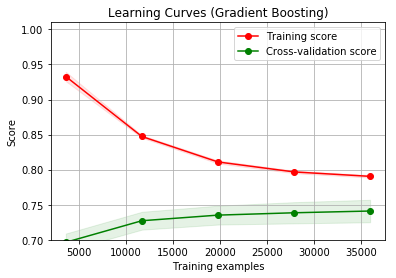

In [6]:
# строим кривые обучения для градиентного бустинга
X = data_new_mean.drop('labels', axis =1)
y = data['labels']

title = "Learning Curves (Gradient Boosting)"
estimator = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=42)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

### Вывод

Как видно из графиков, качество модели на кросс-валидации растет логарифмически с увеличением количества обучающих объектов примерно до 0.72-0.73 (после 20 тыс. объектов), а затем значительное увеличение качества не происходит. Таким образом, для построения модели достаточно около 20 тыс. объектов. 

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [3]:
churn = data[data['labels'] == 1] # формируем класс отток
non_churn = data[data['labels'] == -1]   # формируем класс не отток

churn_share = len(churn)/float(data.shape[0])
non_churn_share = 1-churn_share
print ("доля оттока = ", churn_share)
print ("доля не оттока = ", non_churn_share)

доля оттока =  0.0744
доля не оттока =  0.9256


Т.к. в классификаторе GradientBoostingClassifier нет параметра для выбора соотношения весов (параметр class_weight), то попробуем применить другой классификатор, например, RandomForestClassifier.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=42)

In [10]:
# модель без балансировки классов
rf_classifier = RandomForestClassifier(random_state = 42)
rf_classifier.fit(X_train, y_train)

# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(rf_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,rf_classifier.predict(X_test)))

ROC_AUC на обучении= 0.596698455429
ROC_AUC на тесте= 0.500535678692


In [13]:
# автоматическая балансировка весов
rf_classifier = RandomForestClassifier(random_state = 42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(rf_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,rf_classifier.predict(X_test)))

ROC_AUC на обучении= 0.601115027836
ROC_AUC на тесте= 0.500671155571


In [14]:
# уменьшаем класс неотток (-1) до 60%, а класс отток (1) увеличиваем до 40%
rf_classifier = RandomForestClassifier(random_state = 42, class_weight={-1:0.6, 1:0.4})
rf_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(rf_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,rf_classifier.predict(X_test)))

ROC_AUC на обучении= 0.599730494368
ROC_AUC на тесте= 0.503319962129


In [15]:
# уменьшаем класс неотток (-1) до 30%, а класс отток (1) увеличиваем до 70%
rf_classifier = RandomForestClassifier(random_state = 42, class_weight={-1:0.3, 1:0.7})
rf_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(rf_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,rf_classifier.predict(X_test)))

ROC_AUC на обучении= 0.604482978754
ROC_AUC на тесте= 0.500312998306


In [18]:
# уменьшаем класс неотток (-1) до 5%, а класс отток (1) увеличиваем до 95%
rf_classifier = RandomForestClassifier(random_state = 42, class_weight={-1:0.05, 1:0.95})
rf_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(rf_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,rf_classifier.predict(X_test)))

ROC_AUC на обучении= 0.60217511593
ROC_AUC на тесте= 0.501209948675


### Вывод

Балансировка весов через параметр модели позволяет улучшить качество классификации в случае, когда веса превалирующего класса уменьшаются до 30%.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [38]:
# формируем набор сэмплированных данных 
np.random.seed(42)
sample_size = len(churn)
non_churn_indices = non_churn.index
random_indices = np.random.choice(non_churn_indices, sample_size, replace=False) # 1й вариант выбора индексов
non_churn_sample = data_new_mean.loc[random_indices]
churn_sample = data_new_mean[data_new_mean['labels']==1]
# формируем выборку со сбалансированными классами 
merged_sample = pd.concat([churn_sample, non_churn_sample], ignore_index=True)

#проверяем баланс классов после undersampling'a
churn_undsmpl = merged_sample[merged_sample['labels'] == 1]
non_churn_undsmpl = merged_sample[merged_sample['labels'] == -1]
churn_undsmpl_share = len(churn_undsmpl)/float(merged_sample.shape[0])
non_churn_undsmpl_share = 1-churn_undsmpl_share
print ("доля оттока = ", churn_undsmpl_share)
print ("доля не оттока = ", non_churn_undsmpl_share)

доля оттока =  0.5
доля не оттока =  0.5


In [122]:
# 2й вариант выбора индексов (меняем количество отфильтрованных объектов)
np.random.seed(42)
random_indices = np.random.choice(non_churn_indices, int(len(churn)/0.5), replace=False)
non_churn_sample_2 = data_new_mean.loc[random_indices]
merged_sample_2 = pd.concat([churn_sample, non_churn_sample_2], ignore_index=True)

churn_undsmpl_2 = merged_sample_2[merged_sample_2['labels'] == 1]
non_churn_undsmpl_2 = merged_sample_2[merged_sample_2['labels'] == -1]
churn_undsmpl_share_2 = len(churn_undsmpl_2)/float(merged_sample_2.shape[0])
non_churn_undsmpl_share_2 = 1-churn_undsmpl_share_2
print ("доля оттока = ", churn_undsmpl_share_2)
print ("доля не оттока = ", non_churn_undsmpl_share_2)

доля оттока =  0.3333333333333333
доля не оттока =  0.6666666666666667


In [168]:
# 3й вариант (меняем принцип выбора объектов)
np.random.seed(42)
random_indices = [int(i) for i in np.random.uniform(0, 40000, 5000) if int(i) in non_churn_indices]
non_churn_sample_3 = data_new_mean.loc[random_indices]
merged_sample_3 = pd.concat([churn_sample, non_churn_sample_3], ignore_index=True)

churn_undsmpl_3 = merged_sample_3[merged_sample_3['labels'] == 1]
non_churn_undsmpl_3 = merged_sample_3[merged_sample_3['labels'] == -1]
churn_undsmpl_share_3 = len(churn_undsmpl_3)/float(merged_sample_3.shape[0])
non_churn_undsmpl_share_3 = 1-churn_undsmpl_share_3
print ("доля оттока = ", churn_undsmpl_share_3)
print ("доля не оттока = ", non_churn_undsmpl_share_3)

доля оттока =  0.3893249607535322
доля не оттока =  0.6106750392464678


In [100]:
# проверяем качество первой модели
X = merged_sample.drop('labels', axis =1)
y = merged_sample['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=42)
# Градиентный бустинг 
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.723462871012
ROC_AUC на тесте= 0.67392980183


In [101]:
# проверяем качество второй модели
X = merged_sample_2.drop('labels', axis =1)
y = merged_sample_2['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Градиентный бустинг 
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.718395047477
ROC_AUC на тесте= 0.620118239091


In [171]:
# проверяем качество третьей модели
X = merged_sample_3.drop('labels', axis =1)
y = merged_sample_3['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Градиентный бустинг 
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.729315857604
ROC_AUC на тесте= 0.649092004326


### Вывод

Результаты классификации меняются в зависимости от способов балансировки классов. Наилучший результат был получен в случае, когда индексы большего класса сэмплировались из равномерного распределения в количестве 4668 объектов. При этом, баланс классов оставался несколько смещен в сторону большего класса. При этом, наилучший результат на тестовой выборке показала балансировка классов, с равенством доли большего и меньшего классов (первый вариант).

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Первый способ обработки пропущенных значений был - заполнение их средними по столбцам (работаем с вещественными и закодированными категориальными данными). Далее попробуем заполнить их 0 и медианами 

In [180]:
# замена пропущенных значений на средние по столбцам
X = data_new_mean.drop('labels', axis =1)
y = data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.712237717463
ROC_AUC на тесте= 0.507630306956


In [177]:
# замена пропущенных значений на 0
data_zeros = pd.concat([num_features,encoding_cat_data], axis = 1).fillna(0)
data_zeros['labels'] = data['labels']

X = data_zeros.drop('labels', axis =1)
y = data_zeros['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.714789827253
ROC_AUC на тесте= 0.507046354893


In [178]:
# замена пропущенных значений на медианы по столбцам
data_median = data_new[data_new.columns[0]].fillna(data_new.median(axis=0)[0])
for i in range(len(data_new.columns)-1):
    data_median = np.vstack((data_median,data_new[data_new.columns[i+1]].fillna(data_new.median(axis=0)[i+1]))) 
data_new_median = pd.DataFrame(data_median.transpose(),columns=data_new.columns)
data_new_median['labels'] = data['labels']

In [179]:
X = data_new_median.drop('labels', axis =1)
y = data_new_median['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.714789827253
ROC_AUC на тесте= 0.507046354893


### Вывод

Наиболее оптимистичными по качеству на обучающих данных оказались стратегии заполнения пропущенных значений нулями и медианами. Однако, на тестовых данных лучший результат оказался при заполнении средними.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

В первом варианте категориальные данные кодировались заменой каждой категории числом входящих в неё объектов (пропущенные значения обрабатывались по той же стратегии, что и вещественные). Далее попробуем другие принципы кодирования: 
2. Заменим пропущенные категориальные значения на 'Nan', приведем к строковому типу, отбросим признаки, у которых более 1000 уникальных значений и применим DictVectorizer
3. Заменим пропущенные категориальные значения на 'Nan' и применим LabelEncoder

In [11]:
# 2й вариант (с DictVectorizer) 
cat_features = data.iloc[:, 174:].fillna('NA').applymap(str)
# список признаков, количество уникальных значений которых меньше 1000
features_to_encode = []
for f in cat_features.columns:
    if len(np.unique(cat_features[f])) <1000:
        features_to_encode.append(f)
cat_features_to_encode = cat_features[features_to_encode].drop('labels', axis = 1)

encoder = DV(sparse = False)
encoder.fit(cat_features_to_encode.T.to_dict().values())
encoded_cat_features = encoder.transform(cat_features_to_encode.T.to_dict().values())

num_features_mean = num_features[num_features.columns[0]].fillna(num_features.mean(axis=0)[0])
for i in range(len(num_features.columns)-1):
    num_features_mean = np.vstack((num_features_mean,num_features[num_features.columns[i+1]].fillna(num_features.mean(axis=0)[i+1])))
num_features_new_mean = pd.DataFrame(num_features_mean.transpose(),columns=num_features.columns)

data_new = pd.concat([num_features_new_mean,pd.DataFrame(encoded_cat_features)], axis = 1)
data_new['labels'] = data['labels']
data_new.shape

(40000, 1185)

In [216]:
X = data_new.drop('labels', axis =1)
y = data_new['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.707417510935
ROC_AUC на тесте= 0.508304576938


In [243]:
# 3й вариант (LabelEncoder)
encoder = LabelEncoder()
encoder.fit(np.unique(cat_features_to_encode.as_matrix()))
encoded_cat_features = pd.DataFrame([encoder.transform(i) for i in cat_features_to_encode.values])


num_features_mean = num_features[num_features.columns[0]].fillna(num_features.mean(axis=0)[0])
for i in range(len(num_features.columns)-1):
    num_features_mean = np.vstack((num_features_mean,num_features[num_features.columns[i+1]].fillna(num_features.mean(axis=0)[i+1])))
num_features_new_mean = pd.DataFrame(num_features_mean.transpose(),columns=num_features.columns)

data_new = pd.concat([num_features_new_mean,pd.DataFrame(encoded_cat_features)], axis = 1)
data_new['labels'] = data['labels']
data_new.shape

(40000, 204)

In [244]:
X = data_new.drop('labels', axis =1)
y = data_new['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.693612418208
ROC_AUC на тесте= 0.505071818318


### Вывод

Наилучший результат по качеству на обучении и тесте показал первый вариант, когда категориальные данные кодировались заменой каждой категории числом входящих в неё объектов

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [16]:
X = data_new_mean.drop('labels', axis =1)
y = data['labels']

# 1я стратегия: с применением метода опорных векторов
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.736774447657
ROC_AUC на тесте= 0.508304576938


In [17]:
# 2я стратегия: применение решающего дерева для отбора признаков
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.741693392652
ROC_AUC на тесте= 0.506194563484


###  Вывод

Наилучшей, из рассмотренных, оказалась стратегия отбора признаков на основе решающего дерева, т.к. это более сложная стратегия по сравнению с линейным методом опорных векторов и более подходящая для нашей задачи.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

# выберем оптимальные стратегии обработки данных: 
1. Балансировка классов методом undersampling (с одинаковыми долями каждого класса)
2. Заполнение пропущенных вещественных значений на средние по столбцам
3. Обработка категориальных признаков DictVectorizer'ом
4. Отбор признаков с использованием решающего дерева

In [4]:
# формируем набор сэмплированных данных 
np.random.seed(42)
sample_size = len(churn)
non_churn_indices = non_churn.index
random_indices = np.random.choice(non_churn_indices, sample_size, replace=False)
non_churn_sample = data.loc[random_indices]
churn_sample = data[data['labels']==1]
# формируем выборку со сбалансированными классами 
data_sample = pd.concat([churn_sample, non_churn_sample], ignore_index=True)
# удаляем полностью пустые столбцы
empty_cols = data_sample.columns[np.where(data_sample.count() == 0)]
for cols in empty_cols:
    data_sample.drop(cols, axis =1, inplace = True)
# формируем вещественную часть и категориальную          
cat_features = data_sample.iloc[:, 174:]
num_features = data_sample.drop(cat_features, axis = 1)

In [5]:
# заменяем пропущенные вещественные значения на средние по столбцам
num_features_mean = num_features[num_features.columns[0]].fillna(num_features.mean(axis=0)[0])
for i in range(len(num_features.columns)-1):
    num_features_mean = np.vstack((num_features_mean,num_features[num_features.columns[i+1]].fillna(num_features.mean(axis=0)[i+1]))) 
num_features_new_mean = pd.DataFrame(num_features_mean.transpose(),columns=num_features.columns)

In [6]:
# кодируем категориальные данные с использованием DictVectorizer
cat_features = data_sample.iloc[:, 174:].fillna('NA').applymap(str)
# список признаков, количество уникальных значений которых меньше 1000
features_to_encode = []
for f in cat_features.columns:
    if len(np.unique(cat_features[f])) <1000:
        features_to_encode.append(f)
cat_features_to_encode = cat_features[features_to_encode].drop('labels', axis = 1)

encoder = DV(sparse = False)
encoder.fit(cat_features_to_encode.T.to_dict().values())
encoded_cat_features = encoder.transform(cat_features_to_encode.T.to_dict().values())

# объединяем обработанные данные
data_result = pd.concat([num_features_new_mean,pd.DataFrame(encoded_cat_features)], axis = 1)
data_result['labels'] = data_sample['labels']
data_result.shape

(5952, 1705)

In [7]:
# проводим отбор признаков с решающим деревом
X = data_result.drop('labels', axis = 1)
y = data_sample['labels']
clf = ExtraTreesClassifier(random_state=42)
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

(5952, 363)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=42)

In [9]:
# делаем подбор параметров
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

param_grid = {'n_estimators':np.arange(20,81,10),
              'max_depth': [1,2,3,4,5]}
grid_cv = GridSearchCV(gb_classifier, param_grid, cv = cv)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1  1 ..., -1  1], n_folds=10, shuffle=True, random_state=42),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5], 'n_estimators': array([20, 30, 40, 50, 60, 70, 80])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [10]:
grid_cv.best_params_

{'max_depth': 2, 'n_estimators': 80}

In [11]:
# итоговые оценки по roc_auc 
print ("ROC_AUC с подбором параметров на обучении=", roc_auc_score(y_train,grid_cv.predict_proba(X_train)[:,1]))
print ("ROC_AUC с подбором параметров на тесте=", roc_auc_score(y_test,grid_cv.predict_proba(X_test)[:,1]))

ROC_AUC с подбором параметров на обучении= 0.777061306688
ROC_AUC с подбором параметров на тесте= 0.74401999779


In [12]:
gb_classifier = GradientBoostingClassifier(n_estimators=80, max_depth = 2, random_state=42)
gb_classifier.fit(X_train, y_train)
# оценка по основной метрике - ROC_AUC 
print ("ROC_AUC на обучении=", cross_val_score(gb_classifier, X_train, y_train, scoring = 'roc_auc', cv=cv, n_jobs=-1).mean())
print ("ROC_AUC на тесте=", roc_auc_score(y_test,gb_classifier.predict(X_test)))

ROC_AUC на обучении= 0.730598280143
ROC_AUC на тесте= 0.673271913701


### Вывод

После подбора параметров качество (как на обучении, так и на тесте) выросло. Оптимальными параметрами оказались 80 деревьев с глубиной 2.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [13]:
# оценим важность признаков с помощью метода feature_importances_ нашего классификатора 
importances = gb_classifier.feature_importances_
feature_importances = pd.DataFrame({'Важность признака': importances})
feature_importances.sort_values('Важность признака', ascending=False)

,Важность признака
31,0.219183
46,0.074742
17,0.059034
305,0.056785
16,0.048698
307,0.040057
12,0.035289
26,0.033637
20,0.027847
9,0.026135


In [14]:
# наиболее важные признаки для модели (важность более 0.04)
print ("Важные признаки: ", X.columns[feature_importances[feature_importances['Важность признака']>0.04].index])

# наименее важные признаки для модели (важность 0, ограничимся 5 признаками, т.к. их много)
print ("Неважные признаки: ", X.columns[feature_importances[feature_importances['Важность признака']==0].index][:5])

Важные признаки:  Index(['Var19', 'Var21', 'Var37', 'Var57', 131, 133], dtype='object')
Неважные признаки:  Index(['Var2', 'Var3', 'Var7', 'Var12', 'Var17'], dtype='object')


In [15]:
#сделаем отбор признаков (важность более 0)
important_feature_indexes = feature_importances[feature_importances['Важность признака']>0].index
X_important = X_new[:,important_feature_indexes]

X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=42)
cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=42)


grid_cv.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1  1 ..., -1  1], n_folds=10, shuffle=True, random_state=42),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5], 'n_estimators': array([20, 30, 40, 50, 60, 70, 80])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [16]:
grid_cv.best_params_

{'max_depth': 5, 'n_estimators': 30}

In [17]:
# итоговые оценки по roc_auc 
print ("ROC_AUC с подбором параметров на обучении=", roc_auc_score(y_train,grid_cv.predict_proba(X_train)[:,1]))
print ("ROC_AUC с подбором параметров на тесте=", roc_auc_score(y_test,grid_cv.predict_proba(X_test)[:,1]))

ROC_AUC с подбором параметров на обучении= 0.849149985892
ROC_AUC с подбором параметров на тесте= 0.731469902874


### Вывод

Отбор признаков методом feature_importances и новый подбор параметров (оптимальные параметры: 30 деревьев с максимальной глубиной 5) классификатора позволяет еще сильнее улучшить качество модели.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [18]:
# формируем таблицу с предсказаниями вероятностей классов и реальными (тестовыми) классами
pred_proba = pd.DataFrame(grid_cv.predict_proba(X_test), columns = ['Non_churn (-1)', 'Churn (1)'])
errors_table = pd.concat([pred_proba,pd.DataFrame(y_test.values, columns = ['Test_labels'])], axis=1)
errors_table['y_index'] = y_test.index
errors_table.head(10)

,Non_churn (-1),Churn (1),Test_labels,y_index
0,0.342375,0.657625,-1,4039
1,0.497601,0.502399,-1,4247
2,0.351790,0.648210,1,1966
3,0.793192,0.206808,-1,4765
4,0.176305,0.823695,1,1374
5,0.566571,0.433429,-1,5192
6,0.580050,0.419950,1,1894
7,0.410533,0.589467,-1,3960
8,0.498746,0.501254,-1,4801
9,0.229175,0.770825,1,2899


In [19]:
# список ошибок по классу "1" (т.е. класс 1, но предсказывается класс -1 с вероятностью > 0.5)
churn_lab = errors_table[errors_table['Test_labels'] == 1]
churn_er_ind = churn_lab[churn_lab['Non_churn (-1)'] >=0.5].index
# список объектов, на которых получаются ошибки по 1 классу
index_churn_error = errors_table.loc[churn_er_ind]['y_index'].values

# список ошибок по классу "-1" (т.е. класс -1, но предсказывается класс 1 с вероятностью > 0.5)
non_churn_lab = errors_table[errors_table['Test_labels'] == -1]
non_churn_er_ind = churn_lab[churn_lab['Churn (1)'] >=0.5].index
# список объектов, на которых получаются ошибки по -1 классу
index_non_churn_error = errors_table.loc[non_churn_er_ind]['y_index'].values

print ("Количество ошибок на классе отток", len(index_churn_error), ", что составляет", round(len(index_churn_error)*100/len(churn_lab), 1),"% от общего количество объектоов данного класса")
print ("Количество ошибок на классе неотток", len(index_non_churn_error), ", что составляет", round(len(index_non_churn_error)*100/len(non_churn_lab), 1),"% от общего количество объектоов данного класса")

Количество ошибок на классе отток 312 , что составляет 33.8 % от общего количество объектоов данного класса
Количество ошибок на классе неотток 612 , что составляет 71.0 % от общего количество объектоов данного класса


Посмотрим как себя ведут отобранные признаки (4 наиболее важных): ['Var19', 'Var21', 'Var37', 'Var57'].

In [81]:
# смотрим объекты, на которых возникает ошибка по классу отток
X_test_frame = pd.DataFrame(X_test, index = y_test.index, columns = X.columns[feature_importances[feature_importances['Важность признака']>0].index])
X_test_frame_churn = X_test_frame.loc[index_churn_error]
X_to_analyse = X_test_frame_churn[['Var19', 'Var21', 'Var37', 'Var57']]
X_to_analyse.describe()

,Var19,Var21,Var37,Var57
count,312.000000,312.000000,312.000000,312.000000
mean,68.980769,127.473929,4.505448,258.053665
std,53.014343,435.201215,20.037931,46.792292
min,4.000000,0.000000,-30.000000,114.000000
25%,28.000000,0.000000,1.617564,253.140675
50%,55.000000,28.000000,4.000000,253.140675
75%,104.500000,91.000000,10.000000,253.140675
max,258.000000,5978.000000,64.000000,420.000000


Рассмотрим уникальные значения данных признаков

In [64]:
np.unique(X_to_analyse['Var19'])

array([   4.,    6.,    8.,   10.,   12.,   14.,   16.,   18.,   20.,
         22.,   24.,   26.,   28.,   30.,   32.,   34.,   36.,   38.,
         40.,   42.,   44.,   46.,   48.,   50.,   52.,   54.,   56.,
         58.,   60.,   62.,   64.,   66.,   70.,   72.,   74.,   76.,
         78.,   80.,   82.,   84.,   86.,   88.,   90.,   92.,   94.,
         96.,   98.,  100.,  102.,  104.,  106.,  108.,  110.,  112.,
        114.,  116.,  118.,  120.,  124.,  126.,  128.,  130.,  132.,
        134.,  136.,  138.,  142.,  144.,  150.,  154.,  160.,  162.,
        164.,  166.,  170.,  172.,  174.,  176.,  178.,  180.,  190.,
        192.,  194.,  214.,  222.,  228.,  244.,  258.])

In [65]:
np.unique(X_to_analyse['Var21'])

array([    0.        ,     7.        ,    14.        ,    21.        ,
          28.        ,    35.        ,    42.        ,    49.        ,
          56.        ,    63.        ,    70.        ,    77.        ,
          80.99647234,    84.        ,    91.        ,    98.        ,
         105.        ,   112.        ,   119.        ,   126.        ,
         133.        ,   147.        ,   154.        ,   161.        ,
         168.        ,   175.        ,   189.        ,   196.        ,
         203.        ,   210.        ,   217.        ,   224.        ,
         231.        ,   245.        ,   252.        ,   259.        ,
         273.        ,   280.        ,   294.        ,   301.        ,
         308.        ,   315.        ,   322.        ,   329.        ,
         336.        ,   343.        ,   350.        ,   357.        ,
         364.        ,   399.        ,   420.        ,   441.        ,
         490.        ,   504.        ,   532.        ,   560.        ,
      

In [67]:
np.unique(X_to_analyse['Var37'])

array([-30.        , -28.        , -26.        , -24.        ,
       -22.        , -20.        , -18.        , -16.        ,
       -14.        , -12.        ,  -8.        ,  -6.        ,
        -2.        ,   1.61756446,   4.        ,   6.        ,
         8.        ,  10.        ,  12.        ,  14.        ,
        16.        ,  18.        ,  20.        ,  22.        ,
        24.        ,  26.        ,  28.        ,  30.        ,
        32.        ,  34.        ,  36.        ,  38.        ,
        40.        ,  42.        ,  44.        ,  46.        ,
        48.        ,  54.        ,  56.        ,  58.        ,
        60.        ,  62.        ,  64.        ])

In [66]:
np.unique(X_to_analyse['Var57'])

array([ 114.        ,  132.        ,  138.        ,  144.        ,
        150.        ,  156.        ,  162.        ,  174.        ,
        180.        ,  186.        ,  192.        ,  198.        ,
        204.        ,  210.        ,  216.        ,  222.        ,
        228.        ,  234.        ,  240.        ,  246.        ,
        253.14067524,  258.        ,  264.        ,  270.        ,
        276.        ,  282.        ,  288.        ,  294.        ,
        300.        ,  306.        ,  312.        ,  318.        ,
        324.        ,  330.        ,  348.        ,  354.        ,
        360.        ,  366.        ,  372.        ,  378.        ,
        390.        ,  396.        ,  402.        ,  408.        ,
        414.        ,  420.        ])

In [82]:
print (len(np.unique(X_to_analyse['Var19'])))
print (len(np.unique(X_to_analyse['Var21'])))
print (len(np.unique(X_to_analyse['Var37'])))
print (len(np.unique(X_to_analyse['Var57'])))

88
66
43
46


1. Значения Var19 практически представляют собой арифметическую прогрессию с шагом 2
2. Значения Var21 практически представляют собой арифметическую прогрессию с шагом 7
3. Значения Var37 практически представляют собой арифметическую прогрессию с шагом 2, но с минимальным значением -30
4. Значения Var57 практически представляют собой арифметическую прогрессию с шагом 6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001BFEC438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000026C1FE48>]], dtype=object)

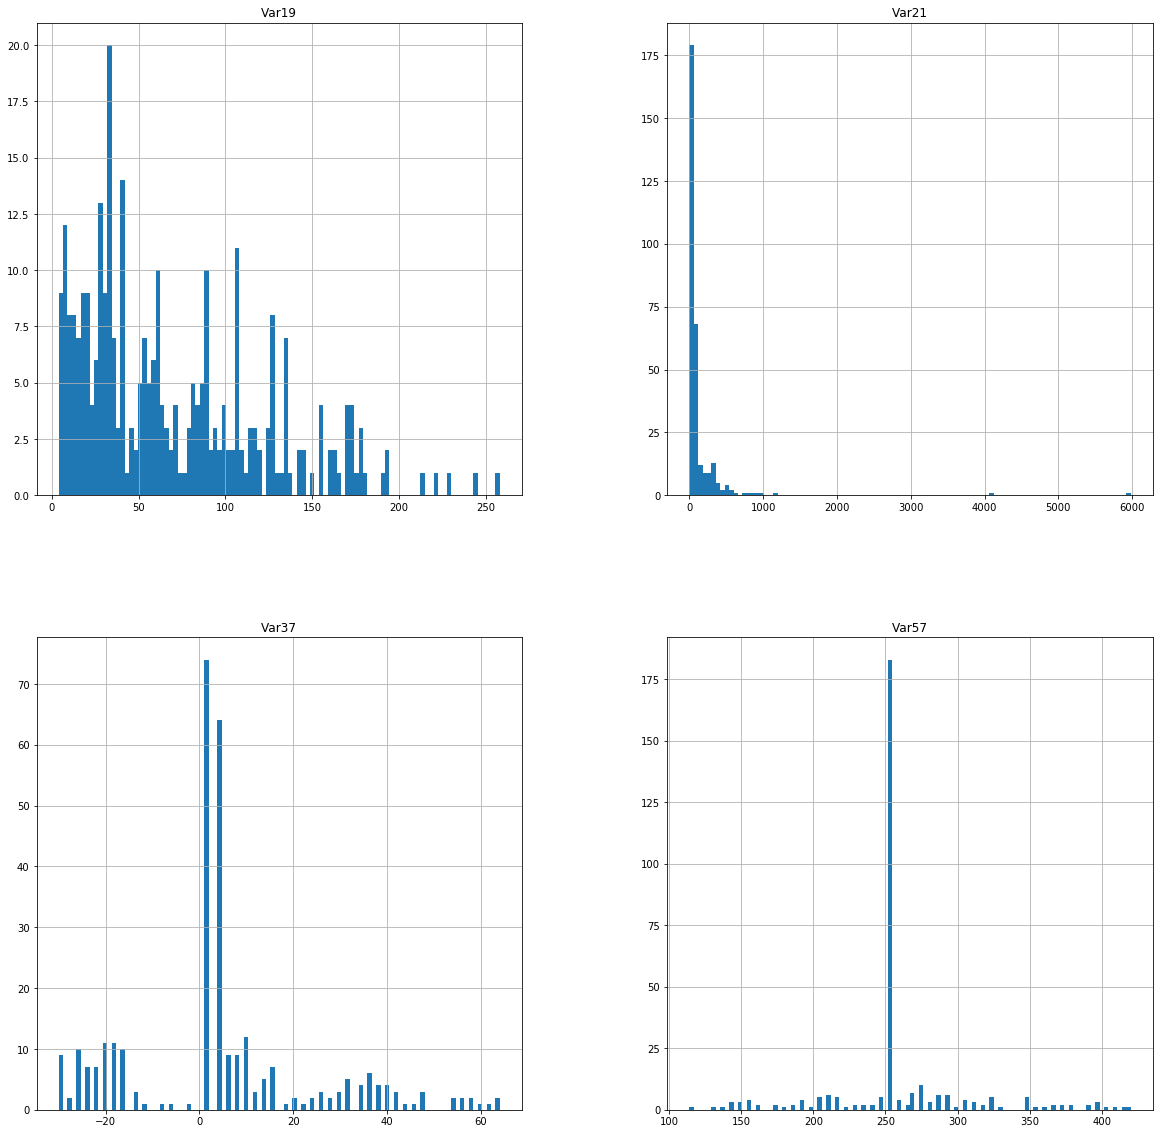

In [46]:
X_to_analyse.hist(bins=100, figsize = [20,20])

Распределения данных признаков не похожи на нормальное, а также не похожи между собой. При этом признак Var19 имеет наибольшее количество различных значений. Признаки Var37 и Var57 имеют выбросы.

In [84]:
# смотрим объекты, на которых возникает ошибка по классу неотток
X_test_frame_non_churn = X_test_frame.loc[index_non_churn_error]
X_to_analyse2 = X_test_frame_non_churn[['Var19', 'Var21', 'Var37', 'Var57']]
X_to_analyse2.describe()

,Var19,Var21,Var37,Var57
count,612.000000,612.000000,612.000000,612.000000
mean,45.516340,38.909941,2.557630,232.787813
std,34.755372,144.336454,9.740796,56.763970
min,4.000000,0.000000,-20.000000,114.000000
25%,18.000000,0.000000,1.617564,198.000000
50%,36.000000,0.000000,1.617564,253.140675
75%,60.000000,21.000000,4.000000,253.140675
max,218.000000,2527.000000,66.000000,636.000000


In [85]:
np.unique(X_to_analyse2['Var19'])

array([   4.,    6.,    8.,   10.,   12.,   14.,   16.,   18.,   20.,
         22.,   24.,   26.,   28.,   30.,   32.,   34.,   36.,   38.,
         40.,   42.,   44.,   46.,   48.,   50.,   52.,   54.,   56.,
         58.,   60.,   62.,   64.,   66.,   68.,   70.,   72.,   74.,
         76.,   78.,   80.,   82.,   84.,   86.,   88.,   90.,   92.,
         94.,   96.,   98.,  100.,  102.,  104.,  106.,  108.,  110.,
        112.,  114.,  116.,  118.,  120.,  124.,  126.,  128.,  130.,
        132.,  134.,  136.,  140.,  146.,  150.,  154.,  156.,  162.,
        192.,  198.,  218.])

In [74]:
np.unique(X_to_analyse2['Var21'])

array([    0.        ,     7.        ,    14.        ,    21.        ,
          28.        ,    35.        ,    42.        ,    49.        ,
          56.        ,    63.        ,    70.        ,    80.99647234,
          84.        ,    91.        ,    98.        ,   105.        ,
         112.        ,   119.        ,   126.        ,   140.        ,
         154.        ,   161.        ,   168.        ,   175.        ,
         189.        ,   196.        ,   203.        ,   210.        ,
         224.        ,   231.        ,   238.        ,   245.        ,
         252.        ,   259.        ,   322.        ,   336.        ,
         343.        ,   385.        ,   413.        ,   434.        ,
         441.        ,   483.        ,   490.        ,   497.        ,
         679.        ,   980.        ,  1092.        ,  1134.        ,
        2527.        ])

In [86]:
np.unique(X_to_analyse2['Var37'])

array([-20.        , -18.        , -14.        , -12.        ,
       -10.        ,  -8.        ,  -6.        ,  -4.        ,
        -2.        ,   0.        ,   1.61756446,   2.        ,
         4.        ,   6.        ,   8.        ,  10.        ,
        12.        ,  14.        ,  16.        ,  18.        ,
        20.        ,  22.        ,  24.        ,  26.        ,
        28.        ,  30.        ,  32.        ,  34.        ,
        36.        ,  38.        ,  40.        ,  44.        ,
        46.        ,  62.        ,  66.        ])

In [87]:
np.unique(X_to_analyse2['Var57'])

array([ 114.        ,  120.        ,  126.        ,  132.        ,
        138.        ,  144.        ,  150.        ,  156.        ,
        162.        ,  168.        ,  174.        ,  180.        ,
        186.        ,  192.        ,  198.        ,  204.        ,
        210.        ,  216.        ,  222.        ,  228.        ,
        234.        ,  240.        ,  246.        ,  252.        ,
        253.14067524,  258.        ,  264.        ,  270.        ,
        276.        ,  282.        ,  288.        ,  294.        ,
        300.        ,  306.        ,  312.        ,  318.        ,
        324.        ,  330.        ,  336.        ,  342.        ,
        354.        ,  360.        ,  402.        ,  408.        ,
        450.        ,  498.        ,  636.        ])

In [83]:
print (len(np.unique(X_to_analyse2['Var19'])))
print (len(np.unique(X_to_analyse2['Var21'])))
print (len(np.unique(X_to_analyse2['Var37'])))
print (len(np.unique(X_to_analyse2['Var57'])))

75
49
35
47


Значения данных признаков на ошибках класса неотток практически сопоставимо со значениями аналогичных признаков на ошибках класса отток. 
1. Значения Var19 практически представляют собой арифметическую прогрессию с шагом 2
2. Значения Var21 практически представляют собой арифметическую прогрессию с шагом 7
3. Значения Var37 практически представляют собой арифметическую прогрессию с шагом 2, но с минимальным значением -20
4. Значения Var57 практически представляют собой арифметическую прогрессию с шагом 6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000026D096A0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000273BB128>]], dtype=object)

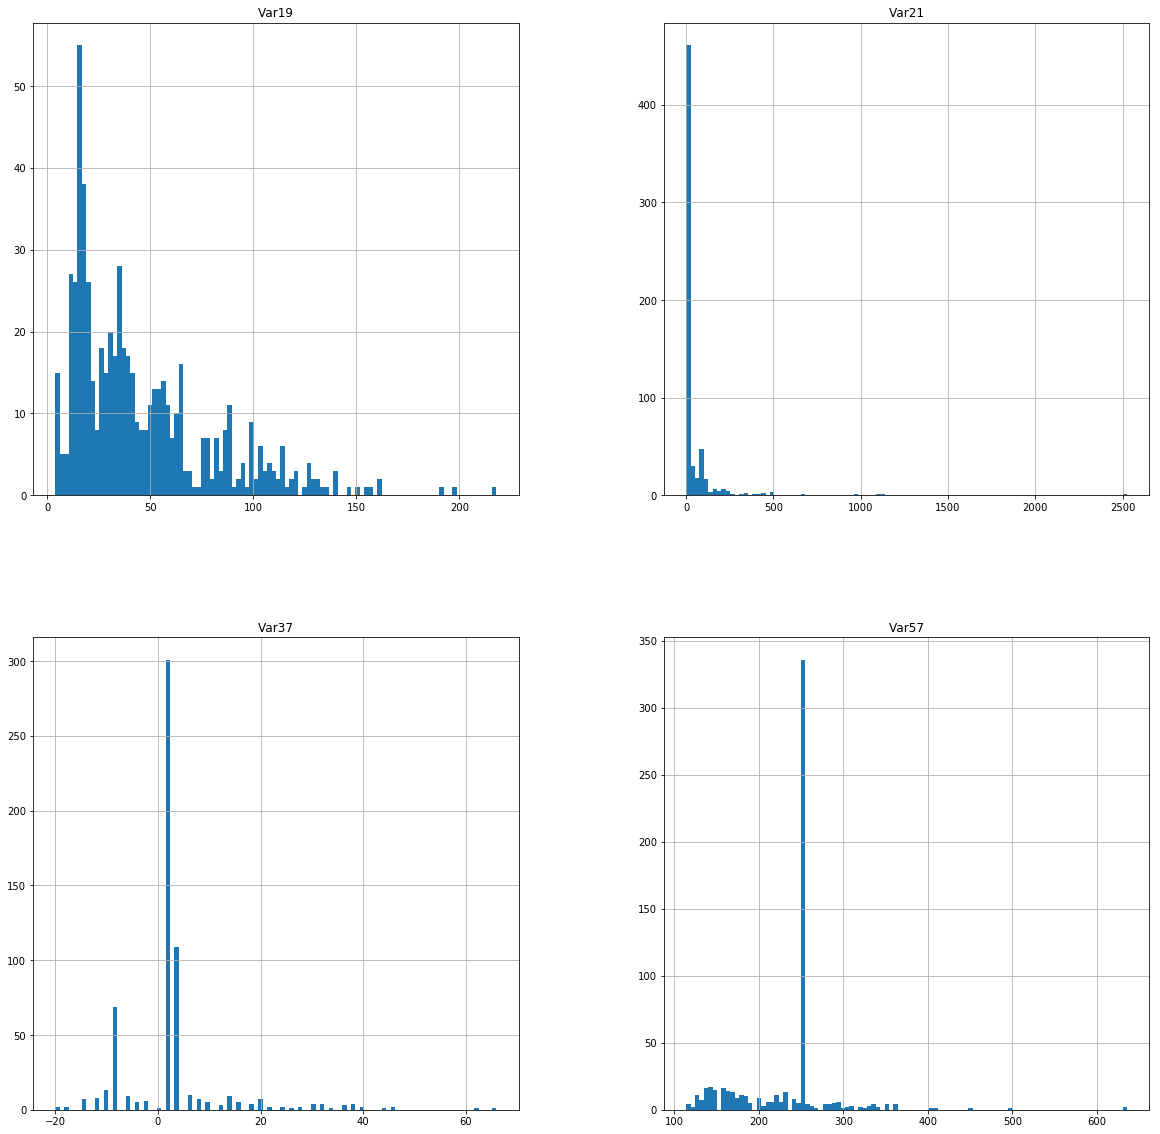

In [76]:
X_to_analyse2.hist(bins=100, figsize = [20,20])

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Преобразования для финальной модели описаны и проведены в пункте 6. Напомним их:

1. Балансировка классов методом undersampling (с одинаковыми долями каждого класса)
2. Заполнение пропущенных вещественных значений на средние по столбцам
3. Обработка категориальных признаков DictVectorizer'ом
4. Отбор признаков с использованием решающего дерева
5. Окончательный отбор признаков с помощью метода feature_importances_
6. Подбор параметров по сетке (перебор количества эстиматоров и максимальной глубины дерева)
7. В итоге получилась модель градиентного бустинга на 70 деревьев с макс глубиной 3

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Можно попробовать отмасштабировать признаки (но в случае градиентного бустинга это не сильно изменить качество модели), а также их нормализовать